In [1]:
import polars as pl
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['timezone'] = 'Europe/Moscow'
import pickle
import numpy as np
import json
from datetime import datetime, timezone, timedelta
from zoneinfo import ZoneInfo

from bot.core.db.postgres_manager import DBManager
from bot.config.credentials import host, user, password, db_name
from bot.utils.files import load_config

db_params = {'host': host, 'user': user, 'password': password, 'dbname': db_name}
db_manager = DBManager(db_params)

from bot.utils.pair_trading import create_zscore_df, round_down, get_lr_zscore, get_dist_zscore, get_tls_zscore
from bot.utils.data import calculate_profit
from bot.core.exchange.trade_api import Trade


In [2]:
with open("./data/coin_information.pkl", "rb") as f:
     coin_information = pickle.load(f)


In [3]:
def switch_pairs(mode, old_token, new_token, keep_token, coin_information, db_manager):
    demo = True if mode == 'demo' else False
    trade_manager = Trade(demo=demo)
    ps = coin_information['bybit_linear'][new_token]['price_scale']
    qty_step = coin_information['bybit_linear'][new_token]['qty_step']
    
    current_pairs = db_manager.get_table('pairs', df_type='polars')
    curr_pair = current_pairs.filter((pl.col('token_1') == old_token) | (pl.col('token_2') == old_token))
    curr_prices = db_manager.get_table('current_ob', df_type='polars')

    curr_pos_side = curr_pair.select(
            pl.when(pl.col('token_1') == old_token).then(pl.col('side_1')).otherwise(pl.col('side_2'))
        ).item()
    qty_to_close = curr_pair.select(
            pl.when(pl.col('token_1') == old_token).then(pl.col('qty_1')).otherwise(pl.col('qty_2'))
        ).item()
    qty_to_keep = curr_pair.select(
            pl.when(pl.col('token_1') == keep_token).then(pl.col('qty_1')).otherwise(pl.col('qty_2'))
        ).item()

    close_price_col = 'bid_price_0' if curr_pos_side == 'long' else 'ask_price_0'
    open_price_col = 'bid_price_0' if curr_pos_side == 'short' else 'ask_price_0'

    close_price = curr_prices.filter(pl.col('token') == old_token).select(close_price_col).item()
    open_price = curr_prices.filter(pl.col('token') == new_token).select(open_price_col).item()
    keep_token_price = curr_prices.filter(pl.col('token') == keep_token).select(open_price_col).item()

    pos_size_to_hedge = round(qty_to_keep * keep_token_price, 8)
    new_size = round_down(pos_size_to_hedge / open_price, qty_step)

    leverage = curr_pair['leverage'].item()
    sl = round(open_price - 0.8 * open_price / leverage, ps) if curr_pos_side == 'long' else round(open_price + 0.8 * open_price / leverage, ps)

    act_old = 'Sell' if curr_pos_side == 'long' else 'Buy'
    act_new = 'Sell' if curr_pos_side == 'short' else 'Buy'
    
    rsp = trade_manager.place_pair_order('linear', old_token, act_old, qty_to_close, None, new_token, act_new, new_size, sl)
    for r in rsp:
        res = trade_manager.get_order('linear', order_id=r)
        if res['token'] == old_token:
            close_price = res['price']
            close_fee = res['fee']
    
    token_1 = curr_pair['token_1'].item()
    token_2 = curr_pair['token_2'].item()

    usdt_amount = open_price * new_size / leverage
    
    db_manager.complete_half_order(token_1, token_2, old_token, close_price, close_fee)
    db_manager.switch_order(old_token, new_token, new_size, open_price, usdt_amount)
    
    print(f'Меняем токен {qty_to_close} {old_token} (цена: {close_price}) на {new_size} {new_token} (цена: {open_price}).')
    print(f'Позиция {old_token}: {curr_pos_side}')
    print(f'Стоимость позиции {qty_to_keep} {keep_token}: {pos_size_to_hedge} (Цена: {keep_token_price})')

    print(f'Действие: {act_old} {qty_to_close} {old_token}; {act_new} {new_size} {new_token}')

In [4]:
def create_spread_hist_df(token_1, token_2, min_order, method, curr_order, hours_back):
    curr_order = orders.filter(
        (pl.col('token_1') == token_1) & (pl.col('token_2') == token_2)
    ).tail(1)

    tf = curr_order['tf'][0]
    wind = curr_order['wind'][0]
    train_len = int(tf[0]) * wind * 2

    ct = curr_order['ct'][0]
    st_time = datetime.strptime(ct, '%Y-%m-%d %H:%M:%S').replace(tzinfo=ZoneInfo("Europe/Moscow"))
    valid_time = st_time - timedelta(hours = hours_back)
    start_time = valid_time - timedelta(hours = train_len)
    thresh_in = curr_order['thresh_in'][0]
    thresh_out = curr_order['thresh_out'][0]
    side = curr_order['side'][0]

    df_1 = db_manager.get_tick_ob(token=token_1 + '_USDT',
                                     start_time=start_time)
    df_2 = db_manager.get_tick_ob(token=token_2 + '_USDT',
                                     start_time=start_time)

    df = make_df_from_orderbooks(df_1, df_2, token_1, token_2, start_time=start_time,
                             )

    if tf == '1h':
        agg_df = make_trunc_df(df, timeframe='1h', token_1=token_1, token_2=token_2, method='triple')[:-1]
    elif tf == '4h':
        agg_df = make_trunc_df(df, timeframe='4h', token_1=token_1, token_2=token_2, method='triple', offset='3h')[:-1]
    else:
        raise NotImplementedError('Введите верный таймфрейм ("1h", "4h")')

    df_sec = make_trunc_df(df, timeframe='1s', token_1=token_1, token_2=token_2, start_date=valid_time, method='last', return_bid_ask=True)

    result_df = create_zscore_df(token_1, token_2, df_sec, agg_df, np.array((wind,)), method, min_order)

    result_df = result_df.select('time', token_1, token_2, f'{token_1}_bid_price', f'{token_1}_ask_price',
                    f'{token_2}_bid_price', f'{token_2}_ask_price', f'beta_{wind}', f'z_score_{wind}').rename(
        {f'beta_{wind}': 'beta', f'z_score_{wind}': 'z_score'}
                    )
    return result_df

In [5]:
def plot_graphs(current_pairs, thr_in, thr_out):
    for row in current_pairs.iter_rows(named=True):
        token_1 = row['token_1']
        token_2 = row['token_2']
        side = row['side_1']
        t1_name = token_1[:-5]
        t2_name = token_2[:-5]
        open_time = row['created_at']

        tf = '4h'
        wind = 24

        start_ts = int(datetime.timestamp(open_time))
        end_ts = int(datetime.timestamp(datetime.now()))
        hist = db_manager.get_zscore_history(token_1, token_2, start_ts, end_ts)

        curr_zscore = round(hist[-1]['z_score'][0], 2)
        curr_profit = round(hist[-1]['profit'][0], 2)

        fig, ax1 = plt.subplots(figsize=(14, 3))

        # График z_score
        ax1.plot(hist.select('time'), hist.select(f'z_score'), color='blue', label='z_score', ls='-', lw=0.75)
        ax1.set_title(f'{token_1[:-5]} - {token_2[:-5]} ({side}; tf: {tf}; wind: {wind}). z_score: {curr_zscore}; profit: {curr_profit}')

        ax1.set_ylabel('z_score')

        if side == 'long':
            ax1.axhline(-thr_in, c='g', linestyle='dotted')
            ax1.axhline(thr_out, c='r', linestyle='dotted')
        else:
            ax1.axhline(thr_in, c='g', linestyle='dotted')
            ax1.axhline(-thr_out, c='r', linestyle='dotted')

        # График профита
        ax2 = ax1.twinx()
        ax2.plot(hist.select('time'), hist.select('profit'), color='green', label='profit', lw=2.0)
        ax2.set_ylabel('profit')
        ax2.grid()
        plt.tight_layout()
        fig.legend(loc='upper right', bbox_to_anchor=(0.135, 0.9))
        plt.show()

In [6]:
config = load_config('./bot/config/config.yaml')
current_pairs = db_manager.get_table('pairs', df_type='polars')

tf = config['tf']
wind = config['wind']
thr_in = config['thresh_in']
thr_out = config['thresh_out']

current_profit = 0

for row in current_pairs.iter_rows(named=True):
    token_1 = row['token_1']
    token_2 = row['token_2']
    side = row['side_1']
    t1_name = token_1[:-5]
    t2_name = token_2[:-5]
    open_time = row['created_at']

    end_ts = int(datetime.timestamp(datetime.now()))
    start_ts = end_ts - 20

    try:
        hist = db_manager.get_zscore_history(token_1, token_2, start_ts, end_ts)
        curr_zscore = round(hist[-1]['z_score'][0], 2)
        curr_profit = round(hist[-1]['profit'][0], 2)
        current_profit += curr_profit
        print(f'{token_1[:-5]:>6} - {token_2[:-5]:6} ({side:>5}, tf: {tf}; wind: {wind:>2}): z_score: {curr_zscore:5}; profit: {curr_profit:5}')
    except IndexError:
        print(f'{token_1[:-5]:>6} - {token_2[:-5]:6} ({side:>5}, tf: {tf}; wind: {wind:>2}): z_score: NaN; profit: NaN')

print(f'{" "*49} current_profit: {current_profit:.2f}')

   GMT - BLUR   ( long, tf: 1h; wind: 72): z_score: -1.85; profit: -0.08
  ARKM - OP     ( long, tf: 1h; wind: 72): z_score: -1.54; profit: -0.26
 MANTA - CELO   (short, tf: 1h; wind: 72): z_score:  3.58; profit: -10.46
   CHZ - VET    (short, tf: 1h; wind: 72): z_score:  0.79; profit: -1.42
                                                  current_profit: -12.22


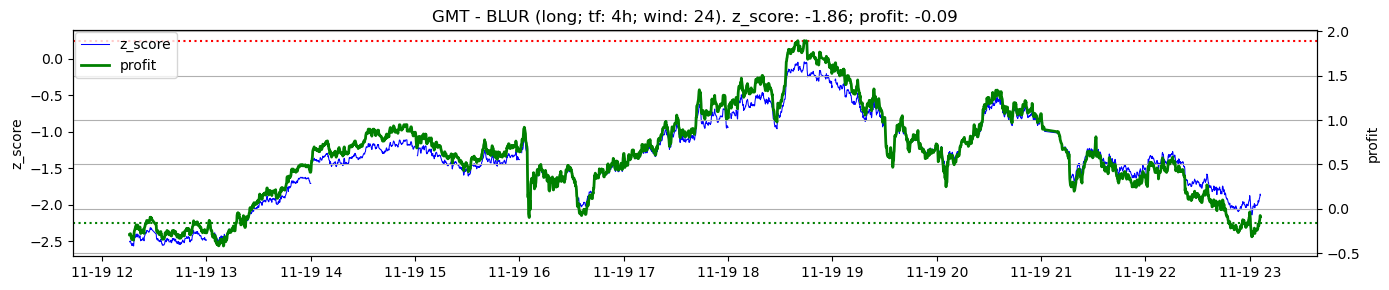

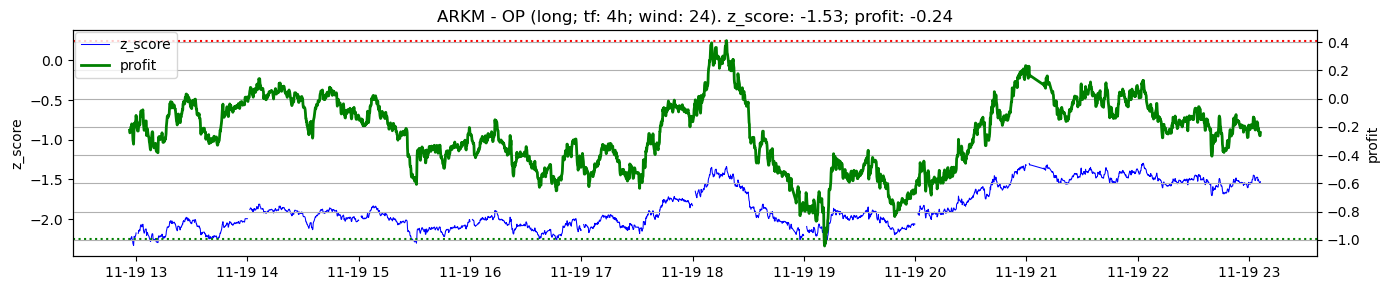

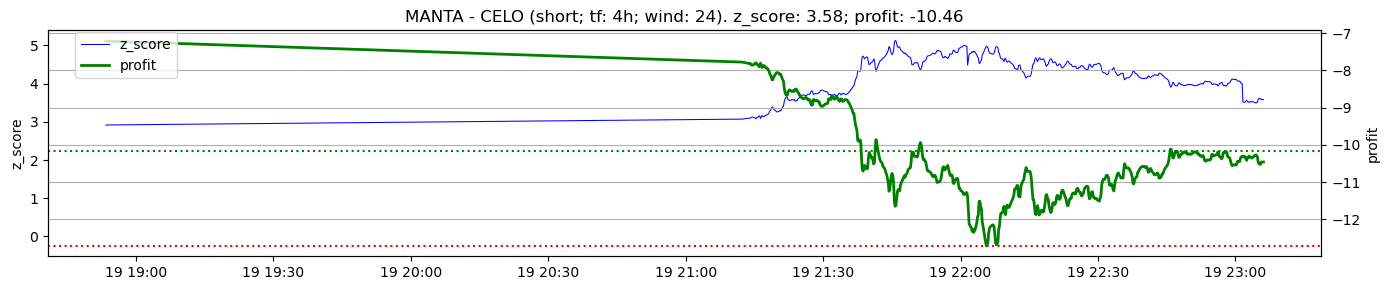

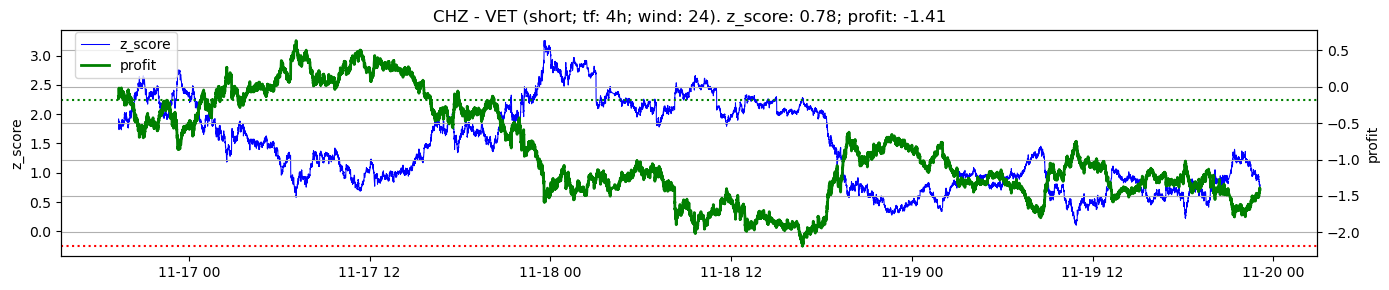

In [7]:
plot_graphs(current_pairs, thr_in, thr_out)

In [ ]:
token_1 = 'CHZ_USDT'
token_2 = 'VET_USDT'
side_1 = 'short'

# db_manager.close_pair_order(token_1, token_2, side_1)

In [ ]:
# switch_pairs('real', 'IOTA_USDT', 'MANTA_USDT', 'CELO_USDT', coin_information, db_manager)

In [ ]:
pairs = db_manager.get_table('pairs', df_type='polars')
pairs.select('token_1', 'token_2', 'created_at', 'mode', 'side_1', 'qty_1', 'qty_2', 'usdt_1', 'usdt_2',
            'rpnl_1', 'rpnl_2', 'upnl_1', 'upnl_2', 'profit_1', 'profit_2', 'profit', 'status')

In [ ]:
db_manager.get_table('trading_history', df_type='polars').sort(by='close_time').tail(1)

In [8]:
from bot.utils.pair_trading import get_lr_zscore, get_dist_zscore

token_pairs = []
with open('./bot/config/token_pairs.txt', 'r') as file:
    for line in file:
        a, b = line.strip().split()
        token_pairs.append((a, b))

In [20]:
tf = '1h'
wind = 72
td = int(tf[0]) * wind * 2 + 1

end_time = datetime.now().replace(tzinfo=ZoneInfo("Europe/Moscow"))
start_time = end_time - timedelta(hours = td)
hist_df = db_manager.get_orderbooks(interval=tf, start_date=start_time)
hist_df = hist_df.with_columns(pl.col('price').alias('avg_price'))

current_data = db_manager.get_table('current_ob', df_type='polars')
current_data = current_data.with_columns(
                    ((pl.col('bid_price_0') + pl.col('ask_price_0')) / 2.0).alias('avg_price')
                )

min_order = 40
end_t = datetime.now().replace(tzinfo=ZoneInfo("Europe/Moscow"))
st_t = end_t - timedelta(seconds = 20)

tick_df = db_manager.get_tick_ob(start_time=st_t).with_columns(
    ((pl.col('bid_price') + pl.col('ask_price')) / 2.0).alias('avg_price')
).filter(
    (pl.col('bid_size') * pl.col('bid_price') > min_order) &
    (pl.col('ask_size') * pl.col('ask_price') > min_order)
)

for t1_name, t2_name in token_pairs:
    token_1 = t1_name + '_USDT'
    token_2 = t2_name + '_USDT'
    z_score = 0

    t1_tick_df = tick_df.filter(pl.col('token') == token_1)
    t2_tick_df = tick_df.filter(pl.col('token') == token_2)
    
    token_1_hist_price = hist_df.filter(pl.col('token') == token_1).tail(td)['avg_price'].to_numpy()
    token_2_hist_price = hist_df.filter(pl.col('token') == token_2).tail(td)['avg_price'].to_numpy()    
    t1_med = np.append(token_1_hist_price, t1_tick_df['avg_price'].median())
    t2_med = np.append(token_2_hist_price, t2_tick_df['avg_price'].median())
    
    _, _, zscore = get_dist_zscore(t1_med, t2_med, np.array([wind]))
    spr, spr_mean, spr_std, alpha, lr_beta, lr_zscore = get_lr_zscore(t1_med, t2_med, np.array([wind]))
    spr, spr_mean, spr_std, alpha, tls_beta, tls_zscore = get_tls_zscore(t1_med, t2_med, np.array([wind]))
    z_score = zscore[0]
    lr_zscore = lr_zscore[0]
    tls_zscore = tls_zscore[0]

    print(f'{token_1[:-5]:>6} - {token_2[:-5]:6}: z_score: {z_score:5.2f}; lr: {lr_zscore:5.2f}; tls: {tls_zscore:5.2f}')

  ARKM - OP    : z_score: -1.46; lr:  0.08; tls:  0.42
 MANTA - CELO  : z_score:  3.38; lr:  1.98; tls:  2.10
  ARKM - CELO  : z_score:  0.49; lr: -0.97; tls: -0.73
 SUSHI - SEI   : z_score:  0.75; lr: -2.02; tls:  0.61
   GMT - BLUR  : z_score: -1.97; lr: -1.09; tls: -0.79
   XRP - LDO   : z_score: -1.27; lr: -2.02; tls: -0.94
  ARKM - STX   : z_score: -1.72; lr: -0.49; tls:  0.16
  ARKM - ONDO  : z_score: -0.62; lr: -0.83; tls: -0.77
   CHZ - VET   : z_score:  0.80; lr: -2.19; tls: -1.97
  IOTA - KAS   : z_score: -0.20; lr: -1.37; tls: -0.92
   GRT - KAS   : z_score: -0.41; lr: -2.14; tls: -1.84
   INJ - ORDI  : z_score:  0.03; lr:  0.12; tls:  0.68
   STX - WIF   : z_score:  1.36; lr:  0.65; tls:  0.74


In [ ]:
end_time = datetime(2025, 11, 18, 13, 34, 10).replace(tzinfo=ZoneInfo("Europe/Moscow"))
start_time = end_time - timedelta(seconds = 10)
token = 'IOTA_USDT'

tick_df = db_manager.get_tick_ob(start_time=start_time, end_time=end_time).with_columns(
    ((pl.col('bid_price') + pl.col('ask_price')) / 2.0).alias('avg_price')
).filter(
    (pl.col('bid_size') * pl.col('bid_price') > min_order) &
    (pl.col('ask_size') * pl.col('ask_price') > min_order)
)
t1_tick_df = tick_df.filter(pl.col('token') == token)
t1_tick_df

In [ ]:
# "IOTA_USDT"	"CELO_USDT"	2025-11-15 20:47:10 MSK	"real"	"short"	370.3	243.5	24.939705	24.970925
open_price = 0.1347
close_price = 0.1248
qty = 370.3
side = 'short'

In [ ]:
calculate_profit(open_price=open_price, close_price=close_price, n_coins=qty, side=side)

In [ ]:
# 2025-11-15 20:47:13. Открываем short позицию 370.3 IOTA (0.1347) - 243.5 CELO (0.2051).
# 2025-11-17 11:15:10. Закрываем ногу IOTA (0.13), открываем 160.4 ARKM (0.291). Доход по IOTA = 1.6865.
# В этот момент убыток по CELO (0.1918) = -3.2917. Размер позиции в usdt в этот момент = 46.7033 usdt.

# 2025-11-18 00:49:10. Закрываем позу. Доход по ARKM = 3.5757, доход по IOTA = 4.9469, убыток по CELO = -6.1391
# Итого, сохранив позицию IOTA - CELO имеем -1.1922 usdt, сменив позицию на ARKM - CELO имеем -0.8769 usdt.

# 2025-11-18 13:34:10. Закрываем позу. Доход по ARKM = 2.5646, доход по IOTA = 3.6131, убыток по CELO = -5.0926

In [ ]:
1.6865 + 3.5757 - 6.1391

In [ ]:
1.6865 + 2.5646 - 5.0926 

In [ ]:
tf = '1h'
wind = 72
winds = np.array([wind,])

token_1 = 'IOTA'
token_2 = 'MANTA'
token_3 = 'CELO'
min_order = 42

valid_length = 5
train_length = 5

end_time = datetime.now().replace(tzinfo=ZoneInfo("Europe/Moscow"))
valid_time = (end_time - timedelta(days=valid_length)).replace(hour=0, minute=0, second=0, microsecond=0)
start_time = valid_time - timedelta(days=train_length)
start_ts = int(datetime.timestamp(valid_time))

df_1 = db_manager.get_tick_ob(token=token_1 + '_USDT',
                                     start_time=start_time,
                                     end_time=end_time)
df_2 = db_manager.get_tick_ob(token=token_2 + '_USDT',
                                     start_time=start_time,
                                     end_time=end_time)
df_3 = db_manager.get_tick_ob(token=token_3 + '_USDT',
                                     start_time=start_time,
                                     end_time=end_time)
print(f'{token_1:>8} first date: {df_1['time'][0]}')
print(f'{token_2:>8} first date: {df_2['time'][0]}')
print(f'{token_3:>8} first date: {df_3['time'][0]}')

df_iota_celo = make_df_from_orderbooks(df_1, df_3, token_1, token_3, start_time=start_time)
tick_df_iota_celo = make_df_from_orderbooks(df_1, df_3, token_1, token_3, start_time=start_time)
df_manta_celo = make_df_from_orderbooks(df_2, df_3, token_2, token_3, start_time=start_time)
tick_df_manta_celo = make_df_from_orderbooks(df_2, df_3, token_2, token_3, start_time=start_time)

agg_df_iota_celo = make_trunc_df(df_iota_celo, tf, token_1, token_3, method='triple')
spread_df_iota_celo = create_zscore_df(token_1, token_3, tick_df_iota_celo, agg_df_iota_celo, tf, winds, min_order, start_ts, 
                                 median_length=6, spr_method='dist')
agg_df_manta_celo = make_trunc_df(df_manta_celo, tf, token_2, token_3, method='triple')
spread_df_manta_celo = create_zscore_df(token_2, token_3, tick_df_manta_celo, agg_df_manta_celo, tf, winds, min_order, start_ts, 
                                 median_length=6, spr_method='dist')

In [ ]:
plt.figure(figsize=(15, 3))
plt.plot(spread_df_iota_celo['time'], spread_df_iota_celo[f'z_score_{wind}_{tf}'], label='IOTA');
plt.plot(spread_df_manta_celo['time'], spread_df_manta_celo[f'z_score_{wind}_{tf}'], label='MANTA');
plt.legend()
plt.grid()